In [446]:
import dolfin as df
import matplotlib.pyplot as plt

import mshr

# Conduction thermique stationnaire 2D avec Fenics

$$
k_{mat} \, \nabla^2 T = 0
$$

La température est fixée (condition de Dirichlet) sur la zone chauffé, de longeur `house_half_size`. Une Isolation vertical (fondation) de hauteur `isolation_depth` et de largeur `isolation_thickness`. Une condition de symmétrie est fixée pour la bordure droite. La température sur la surface extérieure (à gauche de l'isolation), ainsi que sur les cotés dans le sol, gauche et bas, est fixée à 0°C (température moyenne extérieure et température moyenne relative du sol).  

In [466]:
# Geometry
isolation_depth = .6  # m
isolation_thickness = .06  # m
house_half_size = 4  # m
domain_size = 14  # m

domain = mshr.Rectangle(df.Point(-domain_size, -1.5*domain_size),
                        df.Point(house_half_size, 0.))
isolation = mshr.Rectangle(df.Point(0.0, -isolation_depth),
                           df.Point(isolation_thickness, .0))

domain.set_subdomain(1, isolation)

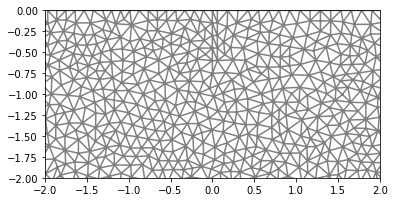

In [467]:
# Mesh
mesh = mshr.generate_mesh(domain, 120)

df.plot(mesh);
plt.xlim([-2, 2]); plt.ylim([-2, 0]);  # zoom

## Conditions aux limites

In [ ]:
class SurfaceExt(df.SubDomain):
    def inside(self, x, on_boundary):
        surface = on_boundary and\
                  df.near(x[1], 0, df.DOLFIN_EPS) and\
                  x[0]<0
        left_side = df.near(x[0], -domain_size, df.DOLFIN_EPS)
        bottom_side = df.near(x[1], -1.5*domain_size, df.DOLFIN_EPS)
        return surface or left_side or bottom_side
    
class SurfaceInt(df.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and\
               df.near(x[1], 0, df.DOLFIN_EPS) and\
               x[0] > isolation_thickness-df.DOLFIN_EPS

# Marquage des frontières:
surface_ext = SurfaceExt()
surface_int = SurfaceInt()

boundary_markers = df.FacetFunction("size_t", mesh)

boundary_markers.set_all(0)
surface_ext.mark(boundary_markers, 1)
surface_int.mark(boundary_markers, 2)

# boundary_markers.array()

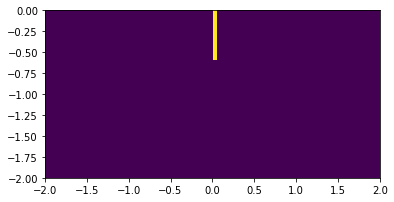

In [471]:
# Marquage des cellules, à partir de la géométrie:
cell_markers = df.CellFunction("size_t", mesh)
markers = df.MeshFunction('size_t', mesh, 2, mesh.domains())

df.plot( markers )
plt.xlim([-2, 2]); plt.ylim([-2, 0]);  # zoom

In [472]:
# Définition des élements infinitésimaux pour les intégrations
dx = df.Measure('dx', domain=mesh, subdomain_data=markers)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

In [473]:
V = df.FunctionSpace(mesh, "Lagrange", 1)

In [474]:
# Define boundary condition
u_ext = df.Constant(0.0)
bc_ext = df.DirichletBC(V, u_ext, surface_ext)

u_int = df.Constant(20.0)
bc_int = df.DirichletBC(V, u_int, surface_int)

bcs = [bc_ext, bc_int]

In [476]:
# Define input data
k_soil = df.Constant(1.28)  # Soil, W/m/K
k_isolant = df.Constant(0.04) # Isolation

f = df.Constant(.0)  # Source

In [477]:
u = df.TrialFunction(V)
v = df.TestFunction(V)

# Define variational form
a = df.inner(k_soil*df.grad(u), df.grad(v))*dx(0)\
    + df.inner(k_isolant*df.grad(u), df.grad(v))*dx(1)

L = f*v*dx(0) + f*v*dx(1)

In [478]:
# Solve problem
u = df.Function(V)
df.solve(a == L, u, bcs)

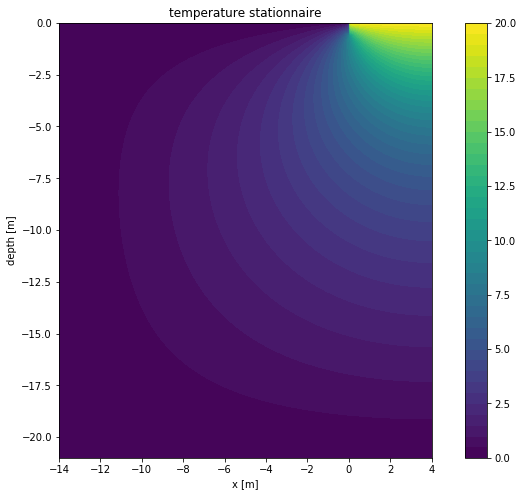

In [481]:
# Graph
plt.figure(figsize=(12, 8))
ax = df.plot(u)
plt.xlabel('x [m]');
plt.ylabel('depth [m]');
#plt.xlim([-2, 2]); plt.ylim([-2, 0]);
plt.colorbar(ax); plt.title('temperature stationnaire');

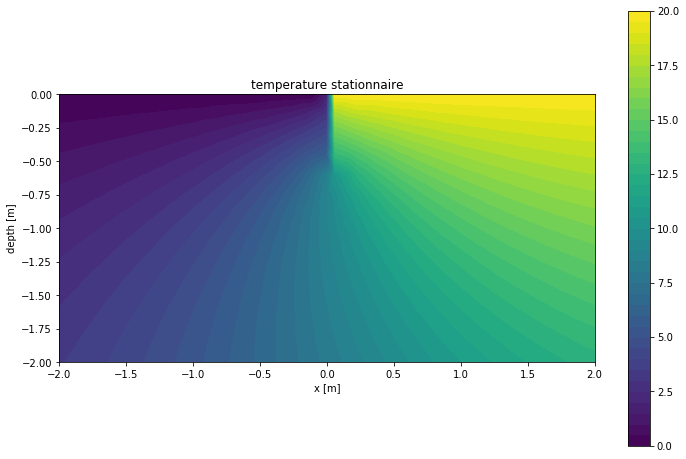

In [496]:
# Zoom
plt.figure(figsize=(12, 8))
ax = df.plot(u)
plt.xlabel('x [m]');
plt.ylabel('depth [m]');
plt.xlim([-2, 2]); plt.ylim([-2, 0]);
plt.colorbar(ax); plt.title('temperature stationnaire');

## Post process

In [484]:
# Length of the interior boundary:
L_int = df.assemble( df.Constant(1.)*ds(2) )
print(L_int)

3.9399999999999995


In [492]:
# Flux chaleur vers le sol (linéïque):
F = df.assemble( k_soil * df.Dx(u, 1)*ds(2) )
print(F, ' W/m')

# Flux moyen surfacique:
print(F/L_int, ' W/m2')

29.41716761162278  W/m
7.466286195843346  W/m2


In [493]:
# Flux sortant de `domain`
n = df.FacetNormal(mesh)
flux_1 = df.assemble( k_soil*df.dot(df.grad(u), n)*ds(1))
flux_1

-27.274098909480514

## Ref et doc pour Fenics
https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html

https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/subdomains-poisson/python/documentation.html

Livre : https://launchpadlibrarian.net/83776282/fenics-book-2011-10-27-final.pdf

Solveur plus recent : https://ngsolve.org/ ?